In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scistats
import pandas as pd
from subject_specificity import simu_maps, part2adj, map2corr, eff_size, permutation_test, simu_stats
sns.set(style="white", context="talk")

Let's start with a function which simulates replicated brain maps, within as well as between subject. The following function uses a simple linear mixture model. The simulations consist of random gaussian noise, where we add a common (random) group map, then a subject-specific (random) map to all replications within a subject. 

In [2]:
y, gt = simu_maps(n_voxel=100, n_replication=40, n_subject=4, within=0.6, between=0.5)

Let's visualize the spatial correlation between maps, along with a dummy matrix encoding within-subject comparisons.

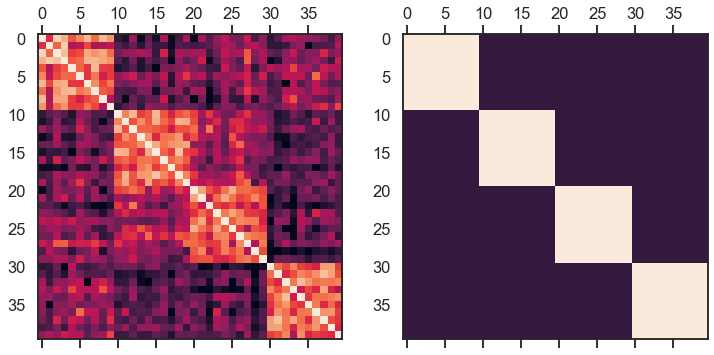

In [3]:
corr_matrix = np.corrcoef(y)
subjects_effect = part2adj(gt)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))
a = ax1.matshow(corr_matrix, vmin = -0.1, vmax = 0.6)
b = ax2.matshow(subjects_effect, vmin = -0.1, vmax = 0.6)
plt.show()

The parameters of the simulation were selected to loosely match the properties of the matrix observed with real data. We can quantify the effect size of within-subject vs between-suject similarity. We generate a Cohen'd based on the difference in mean similarity within-subject, minus the mean similarity inter-subject, divided by a pooled estimate of standard deviation within and between subjects.

In [4]:
data, mask_sub = map2corr(y, gt)
d = eff_size(data, mask_sub)
print(f'effect size is {d}')

effect size is 0.8897804889768944


This is a large effect size, close to 0.9. There is barely a need for statistics to establish the significance of such effects, but let's show our power is indeed > 0.8 for this kind of situation. We need to make a statistical test, so let's check whether the distribution of similarity within-subject is Gaussian:

KstestResult(statistic=0.9969659797031449, pvalue=0.0)

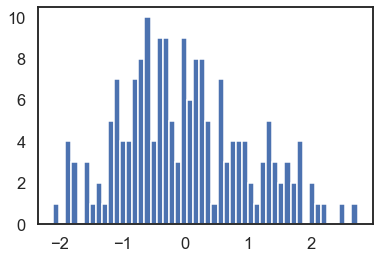

In [5]:
from sklearn.preprocessing import StandardScaler
data_within_n = StandardScaler().fit_transform(np.arctanh(data[mask_sub>0]).reshape(-1, 1))
plt.hist(data_within_n, 50)
scistats.kstest(data_within_n, 'norm')

The distribution is not very far off, but the test is still strongly rejecting the Gaussian hypothesis. So we're going to go with a non-parametric test.

In [6]:
p, diff_permutation, diff = permutation_test(data, mask_sub)
p

9.999000099990002e-05

The test concludes to significantly higher average within-subject similarity than average between-subject similarity. We can visualize the distribution of the difference in average within minus between subject similarity, for the original sample vs permuted samples.

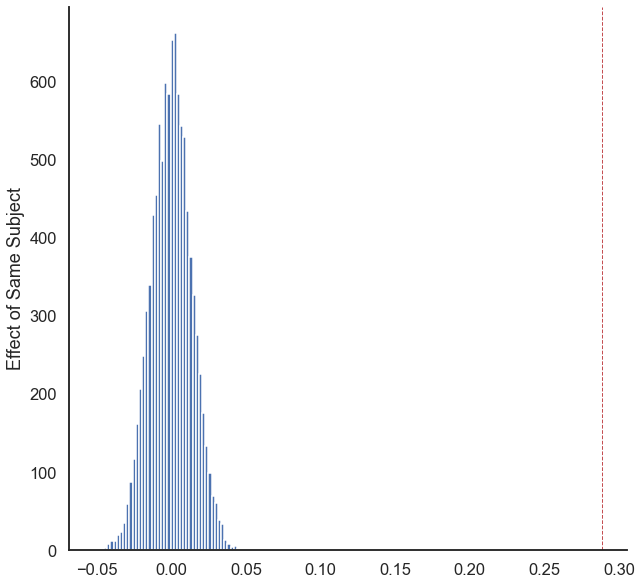

In [7]:
f, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
a = ax1.hist(diff_permutation, bins=50)
ax1.axvline(diff, color='r', linestyle='dashed', linewidth=1)
ax1.set_ylabel("Effect of Same Subject")
sns.despine(left=False, right=True, bottom=False, top=True)
plt.show()

As expected, under the null there is no difference within vs between subject, and the difference (same-subject effect) is centered around 0. The actuall difference is much larger than any sample observed under the null (permutation samples). 

# Checking false positive rate

Now we are going to test that the permutation test does effectively control the false-positive rate under the null. For this purpose we are going to run many simulations, where the within-subject effect is zero. We're going to generate a series of p-values under the null, and observe how they are distributed.

Average (std) of Cohen d: -0.0018422711334055903 (0.024088239935162098)


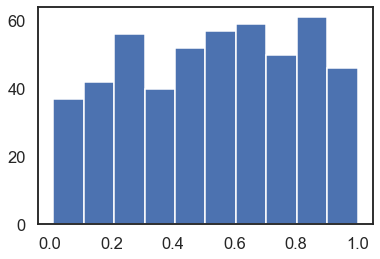

In [8]:
n_simulation = 500
p_values, cohen_d = simu_stats(n_simulation=n_simulation, n_permutation=100, n_voxel=100, n_replication=40, n_subject=4, within=0, between=0.5)
plt.hist(p_values)
print(f'Average (std) of Cohen d: {np.mean(cohen_d)} ({np.std(cohen_d)})')

The p-values seem distributed more or less uniformly between 0 and 1, which is the expected behavior under the null. Note that the average effect size is also minuscule, which again is expected as the data precisely follows the null. Let's check the nominal vs effective false-positive rate for a few thresholds:

In [9]:
list_threshold = [0.05, 0.1, 0.15]
for threshold in list_threshold:
    fpr = np.sum(p_values < threshold) / n_simulation
    print(f'Effective false positive rate with nominal value {threshold}: {fpr}')

Effective false positive rate with nominal value 0.05: 0.04
Effective false positive rate with nominal value 0.1: 0.074
Effective false positive rate with nominal value 0.15: 0.106


So the effective false-positive rate is in general lower than the nominal level. That is the permutation procedure is a bit too conservative. Unfortunate, but acceptable.

# Checking sensitivity

Now we can finally run the statistical power analysis. We are going to run many simulations, where we are going to vary the effect size as well as the p-value threshold. Then we'll be able to plot how the sensitivity (statistical power) varies as a fonction of these parameters. 

In [10]:
n_simulation = 100
n_permutation = 1000
n_voxel = 100
n_replication = 40
n_subject = 4
between = 0.5
list_within = [0, 0.05, 0.1, 0.15, 0.175, 0.2, 0.25]
list_threshold = [0.001, 0.01, 0.05]
df = pd.DataFrame({'p value':[], 'Cohen\'s d':[], 'sensitivity':[]})
row = 0
for within in list_within:
    p_values, cohen_d = simu_stats(n_simulation, n_permutation, n_voxel, n_replication, n_subject, within, between)
    for threshold in list_threshold:        
        sens = np.sum(p_values < threshold) / n_simulation
        print(f'Sensitivity with p={threshold} and d={np.mean(cohen_d)}: {sens}')
        df.loc[row] = [threshold, np.mean(cohen_d), sens]
        row += 1        

Sensitivity with p=0.001 and d=-0.002384158036772456: 0.0
Sensitivity with p=0.01 and d=-0.002384158036772456: 0.0
Sensitivity with p=0.05 and d=-0.002384158036772456: 0.01
Sensitivity with p=0.001 and d=0.0038235459489644134: 0.0
Sensitivity with p=0.01 and d=0.0038235459489644134: 0.01
Sensitivity with p=0.05 and d=0.0038235459489644134: 0.03
Sensitivity with p=0.001 and d=0.028904715640916255: 0.01
Sensitivity with p=0.01 and d=0.028904715640916255: 0.06
Sensitivity with p=0.05 and d=0.028904715640916255: 0.23
Sensitivity with p=0.001 and d=0.05996327363301589: 0.2
Sensitivity with p=0.01 and d=0.05996327363301589: 0.44
Sensitivity with p=0.05 and d=0.05996327363301589: 0.73
Sensitivity with p=0.001 and d=0.08163329687954382: 0.39
Sensitivity with p=0.01 and d=0.08163329687954382: 0.78
Sensitivity with p=0.05 and d=0.08163329687954382: 0.91
Sensitivity with p=0.001 and d=0.10216626345294756: 0.67
Sensitivity with p=0.01 and d=0.10216626345294756: 0.9
Sensitivity with p=0.05 and d=0.

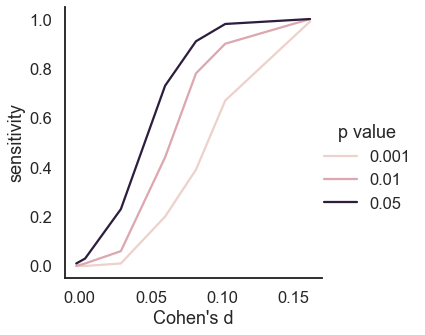

In [11]:
sns.relplot(
    data=df,
    x="Cohen\'s d", y="sensitivity",
    hue="p value", kind="line"
)

In [12]:
data.shape

(780,)

So the statistical power becomes very large with a Cohen's d above 0.1. This may seem counter-intuitive with "only" 4 subjects. But we have 10 repetitions per subject, which means hundreds of within-subject comparisons, and same goes for between subject comparisons. So in total we have almost 800 values to build our statistical test. But these tests strictly apply to those 4 subjects, and it will not be possible to make any inference to the population. However, this is an intrinsic limitation of "deep samples", with a limited number a subjects and many repetition per subject. 